#Autoencoders for MNIST dataset with noise removal

In this notebook, we will see how to implement an autoencoder for the MNIST dataset and how it is possible to add noise to images and then remove it with the use of the created autoencoder.



Import the necessary libraries and load the dataset.

Since the images are resized to 28x28 pixels, we perform a preprocessing by converting the images into a tensor of size 28x28x1.
We also consider the data type "float32".

In [ ]:
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout
from keras.callbacks import TensorBoard
from keras.models import Model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

11493376/11490434 [==============================] - 0s 0us/step


In the following step we normalize the pixel values in the range [0-1], dividing the training and test vectors by the maximum element of each vector.

In [ ]:
max_train, max_test = np.max(x_train), np.max(x_test)

x_train = x_train / max_train
x_test = x_test / max_test


Using the train_test_split function, we divide the training data in order to subsequently consider a test set of 10,000 images.

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(x_train, x_train, test_size=0.2, random_state=42)


We then define the hyperparameters for the autoencoder and create the functions for the Encoder and the Decoder, each having three levels which will be structured as follows:

*Encoder*
- First level: 32 convolutional 3x3 filters plus one downsample.
- Second level: 64 convolutional 3x3 filters plus one downsample.
- Third level: 128 convolutional 3x3 filters.

*Decoder*
- First level: 128 convolutional 3x3 filters plus an upsample.
- Second level: 64 convolutional 3x3 filters plus one downsample.
- Third level: 1 convolutional filter 3x3.



In [ ]:
# Iperparametri
batch_size = 128
epochs = 3
x, y, z = 28, 28, 1
input_img = Input(shape=(x, y, z))

def encoder(input_img):
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='layer_conv_l1')(input_img) # 28x28x32
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), name='max_pool_l1')(x) # 14x14x32

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='layer_conv_l2')(x) # 14x14x64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), name='max_pool_l2')(x) # 7x7x64

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='layer_conv_l3')(x) # 7x7x128
    enc = BatchNormalization()(x)
    return enc


def decoder(bottleneck_layer):

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(bottleneck_layer) #7x7x128
    x = UpSampling2D((2,2))(x) # 14x14x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 14x14x64
    x = UpSampling2D((2,2))(x) # 28x28x64
    
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # 28x28x1
    return dec

def autoencoder(input_img):

    bottleneck_layer = encoder(input_img)
    dec = decoder(bottleneck_layer)
    
    return dec

For the training phase we use the MSE (Meand Square Error) as error function and since the Autoencoder model is a convolutional neural network (CNN), we can use an optimizer based on gradient descent, as in this case Adam, choosing a learning rate of 0.002.

In [ ]:
autoencoder = Model(input_img, autoencoder(input_img))
loss = 'mse'
optimizer = Adam(lr=0.002)
autoencoder.compile(loss=loss, optimizer=optimizer)


In [ ]:

autoencoder_train = autoencoder.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_valid, y_valid))


Epoch 1/3
375/375 [==============================] - 373s 995ms/step - loss: 0.0079 - val_loss: 0.0261
Epoch 2/3
375/375 [==============================] - 378s 1s/step - loss: 0.0023 - val_loss: 0.0032
Epoch 3/3
375/375 [==============================] - 372s 993ms/step - loss: 0.0019 - val_loss: 0.0018


We print below the graph of the loss function for the training set and the validation set

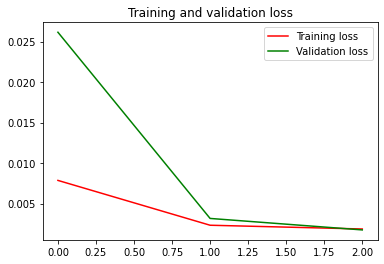

In [ ]:
loss_function = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss_function, 'b', label='Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green')
plt.title('Training and validation loss')
plt.legend()
plt.show()


For the prediction phase, the previously created test set of 10000 images is used.

pred.shape: (10000, 28, 28, 1)
Test Images


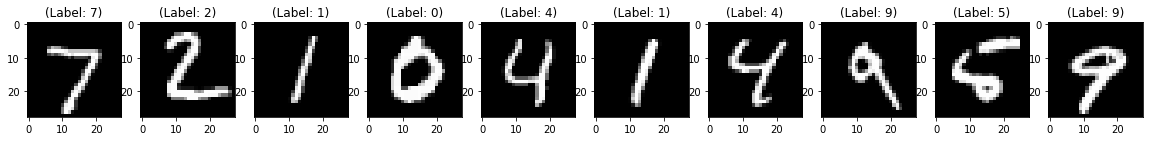

Test Images after autoencoding


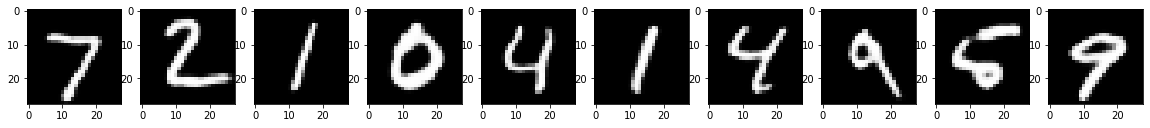

In [ ]:
pred = autoencoder.predict(x_test)
print(f'pred.shape: {pred.shape}')

def plot_images(n_images=10):
    plt.figure(figsize=(20, 4))
    print('Test Images')
    for i in range(n_images):
        plt.subplot(2, n_images, i+1)
        plt.imshow(x_test[i, ..., 0], cmap='gray')
        curr_lbl = y_test[i]
        plt.title(f'(Label: {curr_lbl})')
    plt.show()    
    plt.figure(figsize=(20, 4))
    print('Test Images after autoencoding')
    for i in range(n_images):
        plt.subplot(2, n_images, i+1)
        plt.imshow(pred[i, ..., 0], cmap='gray')  
    plt.show()

plot_images()

#Let's add the noise#
Let's see now how we can add noise to the images and then pass them to the autoencoder and eliminate the added noise.

In this case, we add a noise factor of 0.4

In [ ]:
def add_noise(X, noise_factor=.4):
    X_noisy = X + noise_factor * np.random.normal(loc=0., scale=1., size=X.shape)
    return np.clip(X_noisy, 0., 1.)

X_train_noisy = add_noise(X_train)
X_valid_noisy = add_noise(X_valid)
X_test_noisy = add_noise(x_test)

We first create an autoencoder for images with noise and re-train the model using the images with noise as input and the original images as an example.
This way we could see the loss

In [ ]:
autoencoder_with_denoise = Model(input_img, autoencoder(input_img))
loss = 'mse'
optimizer = Adam(lr=0.001)
autoencoder_with_denoise.compile(loss=loss, optimizer=optimizer)

autoencoder_denoise_train = autoencoder_with_denoise.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=3, verbose=1, validation_data=(X_valid_noisy, X_valid))

Epoch 1/3
375/375 [==============================] - 374s 997ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 2/3
375/375 [==============================] - 374s 998ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 3/3
375/375 [==============================] - 374s 997ms/step - loss: 0.0067 - val_loss: 0.0070


We print below the graph of the loss function for the training set and the validation set.

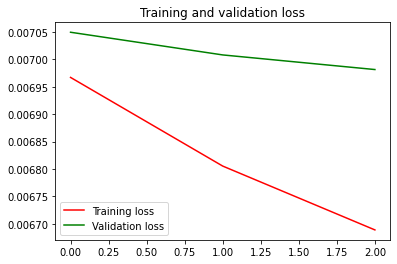

In [ ]:
loss = autoencoder_denoise_train.history['loss']
val_loss = autoencoder_denoise_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green')
plt.title('Training and validation loss')
plt.legend()
plt.show()

For the prediction phase we use the images with noise and compare the results.

Test Images with noise


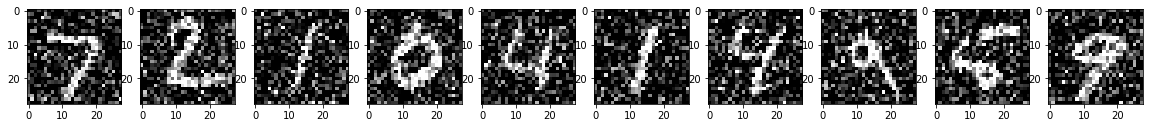

Reconstruction of Test Images with noise


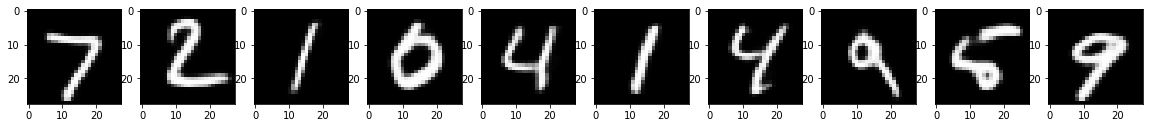

In [ ]:
pred_noisy = autoencoder_with_denoise.predict(X_test_noisy)

def plot_images_noise(n_images=10):
    plt.figure(figsize=(20, 4))
    
    print('Test Images with noise')
    for i in range(n_images):
        plt.subplot(2, n_images, i+1)
        plt.imshow(X_test_noisy[i, ..., 0], cmap='gray')
    plt.show()
    plt.figure(figsize=(20, 4))
   
    print('Reconstruction of Test Images with noise')
    for i in range(n_images):
        plt.subplot(2, n_images, i+1)
        plt.imshow(pred_noisy[i, ..., 0], cmap='gray')  
    plt.show()

plot_images_noise()